In [1]:
import spacy
import re
import numpy as np
import matplotlib.pyplot as plt
import emoji
import os
import torch
import torch.nn.functional as f

from datasets import load_dataset
from unicodedata import normalize
from tqdm import tqdm
from collections import Counter
from transformers import BertTokenizer, BertForSequenceClassification
from sklearn.metrics import accuracy_score
from transformers import TrainingArguments, Trainer, EarlyStoppingCallback
from datasets import Dataset
from sklearn.metrics import classification_report, ConfusionMatrixDisplay

import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from transformers import BertTokenizer, BertModel

from torch.optim import Adam
from tqdm import tqdm
torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

In [3]:
def preprocessar_tweets(tweets):
    repetion_pattern = re.compile(r'(.)\1\1+')
    new_tweets = []
    with tqdm(total=len(tweets), colour='green', desc='Processando') as pbar:
      for tweet in tweets:
          tweet = emoji.demojize(tweet, language='pt')
          tweet = tweet.replace('_', ' ')
          tweet = normalize('NFKD', tweet).encode('ASCII', 'ignore').decode('ASCII')
          tweet = repetion_pattern.sub(r'\1', tweet)
          tweet = re.sub(r'https?://\w+', '', tweet)
          tweet = re.sub(r'@\w+', ' ', tweet)
          tweet = re.sub(r'\s\s+', ' ', tweet)
          new_tweets.append(tweet.strip())
          pbar.update(1)
    return new_tweets

In [4]:
# model_name = 'distilbert'
# model_name = 'bert_base'
model_name = 'bertabaporu'

num_classes = 2

if model_name == 'distilbert':
  model_path = 'adalbertojunior/distilbert-portuguese-cased'
elif model_name == 'bert_base':
  model_path = 'neuralmind/bert-base-portuguese-cased'
elif model_name == 'bertabaporu':
  model_path = 'pablocosta/bertabaporu-base-uncased'

tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path, num_labels=num_classes)

Some weights of the model checkpoint at pablocosta/bertabaporu-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification

In [5]:
dataset = pd.read_csv("./dataset-merged/dataset_merged.csv")


texts = preprocessar_tweets(dataset["tweet"].to_list())
labels = dataset["hatespeech"].to_list()

labels = torch.tensor(labels)

train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, train_size=0.8, random_state=42)
val_texts, test_texts, val_labels, test_labels = train_test_split(test_texts, test_labels, train_size=0.5, random_state=42)

Processando: 100%|█████████████████████████████████████████████████████████████| 12622/12622 [00:01<00:00, 9917.78it/s]


In [6]:
train_dict = {'text': train_texts, 'label': train_labels}
val_dict = {'text': val_texts, 'label': val_labels}
test_dict = {'text': test_texts, 'label': test_labels}

train_dataset = Dataset.from_dict(train_dict)
val_dataset = Dataset.from_dict(val_dict)
test_dataset = Dataset.from_dict(test_dict)

In [7]:
def tokenize_tweet(example, tokenizer, max_len):
  return tokenizer(example['text'], padding='max_length', max_length=max_len, truncation=True)

In [8]:
max_len = 150
batch_size = 32

encoded_train_dataset = train_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                  batched=True, batch_size=batch_size)

encoded_val_dataset = val_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), \
                                      batched=True, batch_size=batch_size)

encoded_test_dataset = test_dataset.map(lambda t: tokenize_tweet(t, tokenizer, max_len), 
                                        batched=True, batch_size=batch_size)

Map:   0%|          | 0/10097 [00:00<?, ? examples/s]

Map:   0%|          | 0/1262 [00:00<?, ? examples/s]

Map:   0%|          | 0/1263 [00:00<?, ? examples/s]

In [9]:
def computar_medidas_eval(eval_pred):
  logits, labels = eval_pred
  predictions = np.argmax(logits, axis=-1)
  labels = np.argmax(labels, axis=-1)
  acc = accuracy_score(labels, predictions)
  return {
      'acc': acc
  }

In [10]:
# Definir hiperparâmetros
num_epochs = 10
learning_rate = 2e-5
device = "cuda:1"

# Variáveis que guardarão dados
train_losses = []
val_accuracies = []


# Criar DataLoader
encoded_train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
encoded_val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
encoded_test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

train_dataloader = DataLoader(encoded_train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(encoded_val_dataset, batch_size=batch_size)
test_dataloader = DataLoader(encoded_test_dataset, batch_size=batch_size)

# Definir otimizador e função de perda
optimizer = Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [11]:
# Função de treinamento
def train(model, dataloader, optimizer, loss_fn):
    model.train()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()

        outputs = model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        total_loss += loss.item()

        _, predicted = torch.max(logits, dim=1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

        loss.backward()
        optimizer.step()

    accuracy = total_correct / total_samples
    return total_loss / len(dataloader), accuracy

# Função de avaliação
def evaluate(model, dataloader):
    model.eval()
    total_loss = 0.0
    total_correct = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating", leave=False):
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            total_loss += loss.item()

            _, predicted = torch.max(logits, dim=1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

    accuracy = total_correct / total_samples
    return total_loss / len(dataloader), accuracy



In [12]:
model.to(device)

# Loop de treinamento
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []
best_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss, train_accuracy = train(model, train_dataloader, optimizer, loss_fn)
    val_loss, val_accuracy = evaluate(model, val_dataloader)

    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Accuracy: {train_accuracy:.4f}")
    print(f"Validation Loss: {val_loss:.4f} | Validation Accuracy: {val_accuracy:.4f}")

    if val_accuracy > best_accuracy:
        best_accuracy = val_accuracy
        torch.save(model.state_dict(), f"{model_name}_{batch_size}_{num_epochs}.pt")

Epoch 1/10
Train Loss: 0.4304 | Train Accuracy: 0.8011
Validation Loss: 0.4161 | Validation Accuracy: 0.8154


Epoch 2/10
Train Loss: 0.3029 | Train Accuracy: 0.8687
Validation Loss: 0.3963 | Validation Accuracy: 0.8281


Epoch 3/10
Train Loss: 0.1789 | Train Accuracy: 0.9272
Validation Loss: 0.5399 | Validation Accuracy: 0.8122


Epoch 4/10
Train Loss: 0.0801 | Train Accuracy: 0.9712
Validation Loss: 0.7113 | Validation Accuracy: 0.7987


Epoch 5/10
Train Loss: 0.0482 | Train Accuracy: 0.9845
Validation Loss: 0.9173 | Validation Accuracy: 0.8043


Epoch 6/10
Train Loss: 0.0362 | Train Accuracy: 0.9874
Validation Loss: 0.7575 | Validation Accuracy: 0.8114


Epoch 7/10
Train Loss: 0.0280 | Train Accuracy: 0.9911
Validation Loss: 1.0319 | Validation Accuracy: 0.8138


Epoch 8/10
Train Loss: 0.0176 | Train Accuracy: 0.9943
Validation Loss: 0.9753 | Validation Accuracy: 0.8106


Epoch 9/10
Train Loss: 0.0173 | Train Accuracy: 0.9943
Validation Loss: 1.1145 | Validation Accuracy: 0.8098


Epoch 10/10
Train Loss: 0.0187 | Train Accuracy: 0.9936
Validation Loss: 1.0255 | Validation Accuracy: 0.8114


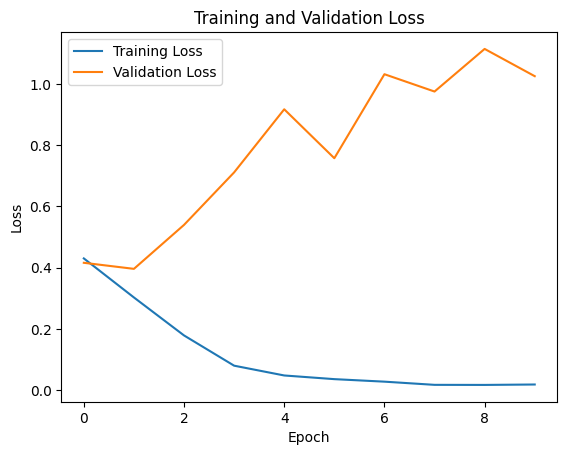

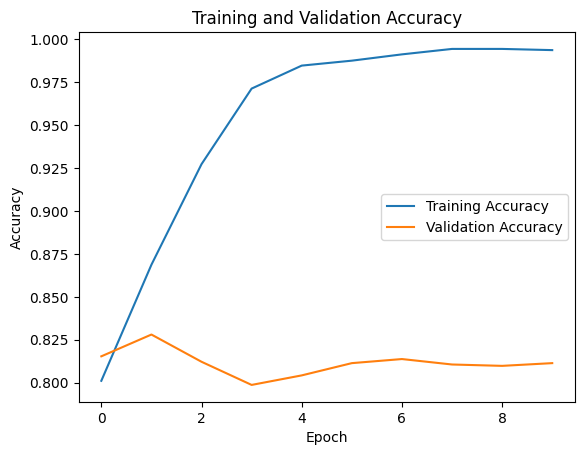

In [13]:
# Gráfico de perda de treinamento e perda de validação
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()

# Gráfico de acurácia de treinamento e acurácia de validação
plt.plot(train_accuracies, label="Training Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training and Validation Accuracy")
plt.legend()
plt.show()

In [14]:
# Carregar o modelo com a melhor acurácia no conjunto de validação
model.load_state_dict(torch.load(f"{model_name}_{batch_size}_{num_epochs}.pt", map_location=device))

# Avaliar o modelo no conjunto de teste
test_loss, test_accuracy = evaluate(model, test_dataloader)
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {test_accuracy:.4f}")


Test Loss: 0.3811 | Test Accuracy: 0.8290
